# Nonlinear analysis - Assignment 2

04.10.2023 - Jérémie Engler and Laure Toullier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import math

np.set_printoptions(precision=5, suppress=True, linewidth=150)

Params = plt.rcParams
Params['figure.figsize'] = (14, 7) 

### Part b

#### Geometry

In [2]:
#Geometric data for the truss:
n=3  #nb of nodes

support=[0,2] #number of the nodes where there is a support
act_P=[1]
rests=[1,1,0,0,1,1] #restraints 
DOF=2*n #degree of freedom

a=3000 #mm
b=4000 #mm

In [3]:
#Material Stiffness
E0 =np.array([200e3, 200e3])  # N/mm^2
E = E0.copy()
sigma_0=np.array([500, 500]) # N/mm^2
eps_0=sigma_0/E
print(eps_0)
alpha=0.02

[0.0025 0.0025]


In [4]:
#Load definition
#load=8675*10**3 #N, value of the applied load
load=10e6
P=np.zeros(DOF).reshape(n,2) 
theta_P=60 #°, inclination of the load regarding the x-axis

    #Application of the load at the corresponding nodes:

P[1]=[load*np.cos(np.radians(theta_P)),load*np.sin(np.radians(theta_P))]
print(P)

[[      0.            0.     ]
 [5000000.      8660254.03784]
 [      0.            0.     ]]


In [5]:
#Generate the nodes of the truss and their location (if 1st node at (0,0))

nodes=np.zeros(n*2).reshape(n,2)

for i in range(n):
    nodes[i,0]=a*i
    if i%2==0:
        nodes[i,1]=0
    else:
        nodes[i,1]=b

print(nodes)

[[   0.    0.]
 [3000. 4000.]
 [6000.    0.]]


In [6]:
#Connectivity: connect nodes with bar element

connectivity=[]

for i in range(n):
    if i<(n-2):
        connectivity.append([i+1, i+2])
#        connectivity.append([i+1, i+3])
    if i==n-2:
        connectivity.append([i+1, i+2])
        
Connectivity=np.array(connectivity)

nb_members=int(np.size(Connectivity)/2)
    
print(Connectivity)

[[1 2]
 [2 3]]


In [7]:
# Area: area of each bar of the truss

#A=10*10**3 #mm²     #members area equal in the entire truss

#area=np.zeros(nb_members)

#for i in range(np.size(area)):
#    area[i]=A
    
area=np.array([15000, 2000])

#### Stiffness

In [8]:
def L_T (nodes, Connectivity, nb_members):

   #angles and length
    angles=[]
    length=[]
    
    for i in range(nb_members):
        
        x1=nodes[Connectivity[i,0]-1,0]      #For each node at the extremity of each bar, we get its location in x and y.
        y1=nodes[Connectivity[i,0]-1,1]
        x2=nodes[Connectivity[i,1]-1,0]
        y2=nodes[Connectivity[i,1]-1,1]
        dx=x2-x1
        dy=y2-y1
        length.append(np.sqrt(dx**2+dy**2))
        
        if np.isclose(y1, y2):
            if np.isclose(x1, x2):
                angles.append(90)
            else:
                angles.append(0)
        else:
            theta=np.arcsin((y2-y1)/np.sqrt(dx**2+dy**2)) #calculate the angle between the x-axis and the bar element
            angles.append(math.degrees(theta))
       
    #Transformation matrix for each bar element of the truss
    c=[]
    s=[]
    for i in range(nb_members):
        c.append(np.cos(np.radians(angles[i])))
        s.append(np.sin(np.radians(angles[i])))
    
    T=np.zeros((nb_members,4,4))

    for i in range(nb_members):
        T[i,0,0]=c[i]
        T[i,0,1]=s[i]
        T[i,1,0]=-s[i]
        T[i,1,1]=c[i]
        T[i,2,2]=c[i]
        T[i,2,3]=s[i]
        T[i,3,2]=-s[i]
        T[i,3,3]=c[i]
    
    return length, T

In [9]:
def stiffness (E, area, nodes, nb_members, DOF, Connectivity, T, L):


    # Unit stiffness matrix of bar in local coordinate system
    K_unit = np.array([[1, 0, -1, 0], 
                   [0, 0,  0, 0], 
                   [-1, 0, 1, 0], 
                   [0, 0, 0, 0]])
    
    #local stiffness matrix for each bar
    k_local=[]
    
    for i in range(nb_members):
        k_local.append(E[i]*area[i]/L[i])
        
    #Stiffness for each bar in global coordinates system
    k_global=[]

    for i in range(nb_members):
        k=k_local[i]*T[i].T@K_unit@T[i] 
        k_global.append(k)

    #Stiffness in global system
    K_globalCS_bar=np.zeros((nb_members, DOF,DOF))
    K_global=np.zeros((DOF,DOF))
    k_global = np.array(k_global)

    for i, ((u, v), k) in enumerate(zip(Connectivity, k_global)):       
        #we build all the global stiffness matrix for each bar in the entire system and sum them.
        K_global[2*u-2:2*u,2*u-2:2*u] += k[0:2, 0:2]
        K_global[2*u-2:2*u,2*v-2:2*v] += k[0:2, 2:4]
        K_global[2*v-2:2*v,2*u-2:2*u] += k[2:4, 0:2]
        K_global[2*v-2:2*v,2*v-2:2*v] += k[2:4, 2:4]
    
        #global stiffness matrix for each bar in the entire system 
        K_globalCS_bar[i, 2*u-2:2*u,2*u-2:2*u] = k[0:2, 0:2]
        K_globalCS_bar[i, 2*u-2:2*u,2*v-2:2*v] = k[0:2, 2:4]
        K_globalCS_bar[i, 2*v-2:2*v,2*u-2:2*u] = k[2:4, 0:2]
        K_globalCS_bar[i, 2*v-2:2*v,2*v-2:2*v] = k[2:4, 2:4]
        
    return (k_local, K_global, K_globalCS_bar)

#### Equilibrium of the entire system : K*U=R

In [10]:
#Calculate the displacements of the nodes with a load applied

def displacement(support, act_P, P, K_global, DOF):
    
    F_red=np.zeros(DOF-2*len(support))

    for i in range(n):
        if i in act_P:
            F_red[i*2-2]=P[i,0]
            F_red[i*2-1]=P[i,1]  
        
    a=2*(n-len(support)) 
    K_red=np.zeros((a,a)) #reduced stiffness matrix for the nodes where there are displacements
    K_red=K_global[2:a+2, 2:a+2]

    u_red=np.linalg.inv(K_red)@F_red #reduced vector displacements for the nodes concerned by displacements

    u_vec=np.zeros(n*2) #global vector for displacements
    u_vec[2:n*2-2]=u_red[:]

    return(u_vec) 


In [11]:
#Support reactions

def support_reactions (K_global, u_vec):
    F = K_global @ u_vec #N
    return(F)

In [12]:
L, T= L_T (nodes, Connectivity, nb_members )
k_local, K_global, K_globalCS_bar=stiffness (E, area, nodes, nb_members, DOF, Connectivity, T, L)
u_vec=displacement(support, act_P, P, K_global, DOF)
appui=support_reactions(K_global, u_vec)
print(appui)

[-5747595.26419 -7663460.35226  5000000.       8660254.03784   747595.26419  -996793.68559]


In [13]:
#Axial forces in each bar of the truss

def axial_load_0(nb_members, K_globalCS_bar,u_vec):

    F_bar=[]
    F_bar_reduced=np.zeros((nb_members,4))
    F_local_CS=[]
    axial_load=[]

    for i in range(nb_members):
        F_bar.append(K_globalCS_bar[i,:,:]@u_vec)   #forces applied at each extermity of each bar in global coordinates in global system
    F_bar=np.array(F_bar)

    for i in range(nb_members): #forces applied at the extremity of each bar in global coordinates in local system
        index_1=Connectivity[i,0] #value of 1st node of the bar
        index_2=Connectivity[i,1] #value of 2nd node of the bar
        F_bar_reduced[i,0]=F_bar[i,(index_1-1)*2] 
        F_bar_reduced[i,1]=F_bar[i,(index_1)*2-1]
        F_bar_reduced[i,2]=F_bar[i,(index_2-1)*2]
        F_bar_reduced[i,3]=F_bar[i,index_2*2-1]     

    for i in range(nb_members): #forces applied at the extremity of each bar in local coordinates in local system
        F_local_CS.append(T[i]@F_bar_reduced[i])   
    F_local_CS=np.array(F_local_CS)

    for i in range(nb_members): #axial load in each bar in N
        axial_load.append(F_local_CS[i,2])
    
    axial_load=np.array(axial_load)
    return axial_load

def axial_load_1(K_globalCS_bar, Connectivity, u_vec, T, nb_members):
    axialF = []
    for i in range(nb_members):
        F_elei = K_globalCS_bar[i,:,:] @ u_vec
        index_red = 2*Connectivity[i]
        F_elei_red = F_elei[[index_red[0]-2, index_red[0]-1, index_red[1]-2, index_red[1]-1]]
        F_elei_local = T[i] @ F_elei_red
        Fi = F_elei_local[2]
        axialF.append(Fi)
    return axialF


In [14]:
L, T= L_T (nodes, Connectivity, nb_members )
k_local, K_global, K_globalCS_bar=stiffness (E, area, nodes, nb_members, DOF, Connectivity, T, L)
u_vec=displacement(support, act_P, P, K_global, DOF)
appui=support_reactions(K_global, u_vec)
axial=axial_load_1(K_globalCS_bar, Connectivity, u_vec, T, nb_members)
print(axial)

[9579325.44031941, 1245992.106986071]


#### Newton Raphson Method

In [15]:
#Initialisation

u=np.zeros((DOF)) #initial nodal displacement
print(u)
L0, T0 = L_T(nodes, Connectivity, nb_members )
k, K_global, K_globalCS_bar = stiffness(E, area, nodes, nb_members, DOF,Connectivity,T, L) #initial stiffness matrix
load_incr = 20 #increment for loadstep
iter_lim = 20
tol=np.max(area)*np.max(sigma_0)/1e5 #tolerance

[0. 0. 0. 0. 0. 0.]


In [16]:
#strains

def strain(Connectivity, u, L0, T, nb_members):
    
    
    u=u.reshape((n,2))
    #displacements in global coordinates
    u_red=np.zeros(nb_members*4).reshape((nb_members,4))
    for i in range(nb_members):  
        u_red[i, 0]=u[Connectivity[i,0]-1,0]      
        u_red[i, 1]=u[Connectivity[i,0]-1,1]
        u_red[i, 2]=u[Connectivity[i,1]-1,0]
        u_red[i, 3]=u[Connectivity[i,1]-1,1]
    
    #displacements in local coordinates
    u_bar=[]
    for i in range(nb_members):
        u_bar.append(T[i]@u_red[i,:])
    
    u_bar=np.array(u_bar)
    
    #calculate the strain in each bar
    strain=[]
    for i in range(nb_members):  
        strain.append((u_bar[i,2]-u_bar[i,0])/L0[i])
        
    strain=np.array(strain)
    
    return strain

In [17]:
def strain_1(L,L0):
    strain=[]
    for i in range(nb_members):
         strain.append((L[i]-L0[i])/L0[i])
    strain=np.array(strain)
    
    return strain    

In [18]:
#internal force for each displacement

def internal_force(Connectivity, area, E, u, L, T, sigma_0, eps_0, nb_members, DOF, rests):
    
    #internal force in each bar
    Pr=[]
    Pr_CS=np.zeros(n*4).reshape((n,4))
    strains=strain_1(L,L0)
    
    for i in range(nb_members):
        if np.abs(strains[i])>eps_0[i]:
            a= (sigma_0[i]*area[i]+E0[i]*alpha * area[i] * (strains[i]-eps_0[i]))*np.sign(strains[i])
        else:
            a=E0[i]*area[i]*strains[i]
            
        Pr.append(a)
        Pr_CS[i,0] = -a
        Pr_CS[i,2] = a

    #internal force at each extremity of a bar in local coordinates
   # Pr_CS=np.zeros((nb_members,4))
   # for i in range(nb_members):
   #     Pr_CS[i,0]=-Pr[i]
   #     Pr_CS[i,1]=0
   #     Pr_CS[i,2]=Pr[i]
   #     Pr_CS[i,3]=0
   #Pr_CS=np.array(Pr_CS)
    #Pr_CS = np.array([np.array([-pr, 0, pr, 0]) for pr in Pr])
    
    #internal force at each extremity of a bar in global coordinates
    Pr_glob=np.zeros((2,4))
    for i in range(nb_members):
        Pr_glob[i,:]=np.transpose(T[i]) @ Pr_CS[i]
    
    #internal force at node 2 for each bar in global coordinates
    Pr_glob_bar1_2=np.array([Pr_glob[0,2],Pr_glob[0,3]])
    Pr_glob_bar2_2=np.array([Pr_glob[1,0],Pr_glob[1,1]])
    #sum of internal force at node 2 in global coordinates
    sum_Pr_glob_2=Pr_glob_bar1_2+Pr_glob_bar2_2
    print("Pr = ", Pr)
    return Pr, Pr_glob, sum_Pr_glob_2


In [19]:
#Generalisation

steps = 1
lams =  np.linspace(1,load_incr)/load_incr
P_applied = np.zeros((load_incr, DOF))
R = P_applied #initialization of R 
delta_u = np.zeros((1,DOF)) #initialization of delta_u (no force, no displacement)

#lists to generate later the graphs !
u1 = []
u2 = []
p1 = []
p2 = []
norm_r_print = []
iteration = []

iteration_counter = 0

#loops:
for i in range (load_incr):
    print(f"################# Nouvelle itération sur {i=} ######################")
    #load P is applied by increment
    P_applied[i,:]=P.reshape((1,6))*lams[i]
    #first increment of displacement is calculated with the function displacement (get the displacement of each node for a load applied)
    delta_u = displacement(support, act_P, P_applied[i,:].reshape(3,2), K_global, DOF)
    print(f'delta_u={delta_u}')
    p1.append(P_applied[i,2])
    print("quesaco", P_applied[i,2])
    p2.append(P_applied[i,3])
    
    for j in range(iter_lim):
        print(f"%%%%%%%%%%%%%% Nouvelle itération sur {j=} %%%%%%%%%%%%%%%%%")
        iteration_counter += 1
        
        #displacement
        u=u+delta_u
        print(f'u={u}')
        nodes=nodes+np.array(delta_u).reshape(3,2) #new global displacements 
        print(f'nodes={nodes}')
        
        #new length with displacement
        L,T=L_T (nodes, Connectivity, nb_members )
        print(f'L={L}')
        
        #has the bar yielded ?
        for m in range(nb_members):
            eps=strain_1(L,L0) #returns an array with the strain of each bar
            #eps=strain(Connectivity, u, L0, T, nb_members)
            print(f'm={m}  {eps[m] = }  {eps_0[m] = }  {np.abs(eps[m]) >= eps_0[m] = }')
            if np.abs(eps[m]) >= eps_0[m]: #the bar has yielded, the Young's modulus of the bar needs to be updated!
                E[m]=alpha*E0[m]   
                k, K_global, K_globalCS_bar=stiffness(E, area, nodes, nb_members, DOF,Connectivity, T, L) #new E, new length, new nodes, new T
            else:
                E[m]=E0[m]  #the bar has not reached its yield limit !
                k, K_global, K_globalCS_bar=stiffness(E, area, nodes, nb_members, DOF,Connectivity, T, L)
        print(f"{K_global = }")
        #internal force Pr at node 2
        Pr, Pr_glob, sum_Pr_glob_2 = internal_force(Connectivity, area, E, u, L, T, sigma_0, eps_0, nb_members, DOF, rests)
        
        #sum of internal force Pr at node 2 in global coordinates:
        sum_Pr_glob=np.zeros(6)
        sum_Pr_glob[2]=sum_Pr_glob_2[0]
        sum_Pr_glob[3]=sum_Pr_glob_2[1]
        print(f'sum_Pr_glob={sum_Pr_glob}')
        
        #Residual force in global coordinates
        R=P_applied[i,:]-sum_Pr_glob
        norm_R=np.linalg.norm(R) 
        norm_r_print.append(norm_R)
        iteration.append(iteration_counter)
    
        if norm_R < tol:
            print(">>>>>>>>>>>>> norm_R < tol")
            u1.append(u[2])
            u2.append(u[3])
            break #if the tolerance is reached, we need to go "out of the loop" to go to the newt load iteration

        if norm_R>tol and j==iter_lim-1:
            raise ValueError("No convergence !")
        
        else:
            #Update the strain-increment delta_u in global coordinates:
            r=R[2:4]
            print(f"r = {r}")
            mini_delta_u=np.linalg.solve(K_global[2:4,2:4], r.reshape((2,1)))
            delta_u[2:4]=mini_delta_u.reshape(1,2)
            print(f'delta_u={delta_u}')

print(E)
print(alpha)

################# Nouvelle itération sur i=0 ######################
delta_u=[0.      0.      0.01628 0.98564 0.      0.     ]
quesaco 250000.00000000006
%%%%%%%%%%%%%% Nouvelle itération sur j=0 %%%%%%%%%%%%%%%%%
u=[0.      0.      0.01628 0.98564 0.      0.     ]
nodes=[[   0.         0.     ]
 [3000.01628 4000.98564]
 [6000.         0.     ]]
L=[5000.798310564942, 5000.77878159168]
m=0  eps[m] = 0.0001596621129883715  eps_0[m] = 0.0025  np.abs(eps[m]) >= eps_0[m] = False
m=1  eps[m] = 0.00015575631833598892  eps_0[m] = 0.0025  np.abs(eps[m]) >= eps_0[m] = False
K_global = array([[ 215898.91471,  287934.59019, -215898.91471, -287934.59019,       0.     ,       0.     ],
       [ 287934.59019,  384005.30331, -287934.59019, -384005.30331,       0.     ,       0.     ],
       [-215898.91471, -287934.59019,  244685.14919,  249543.27831,  -28786.23448,   38391.31188],
       [-287934.59019, -384005.30331,  249543.27831,  435206.61027,   38391.31188,  -51201.30696],
       [      0.     , 

K_global = array([[ 4946.02439,  6196.23929, -4946.02439, -6196.23929,     0.     ,     0.     ],
       [ 6196.23929,  7762.47311, -6196.23929, -7762.47311,     0.     ,     0.     ],
       [-4946.02439, -6196.23929,  5625.15402,  5375.88334,  -679.12964,   820.35595],
       [-6196.23929, -7762.47311,  5375.88334,  8753.42367,   820.35595,  -990.95055],
       [    0.     ,     0.     ,  -679.12964,   820.35595,   679.12964,  -820.35595],
       [    0.     ,     0.     ,   820.35595,  -990.95055,  -820.35595,   990.95055]])
Pr =  [4005005.819497965, 644302.6453286482]
sum_Pr_glob=[      0.            0.      2087664.20192 3626388.18179       0.            0.     ]
r = [ 4172.53277 -3220.67616]
delta_u=[ 0.       0.       2.647   -1.99358  0.       0.     ]
%%%%%%%%%%%%%% Nouvelle itération sur j=7 %%%%%%%%%%%%%%%%%
u=[   0.         0.       -51.99517 -312.13269    0.         0.     ]
nodes=[[   0.         0.     ]
 [2948.00483 3687.86731]
 [6000.         0.     ]]
L=[4721.344913128

In [20]:
def printgraph(x,y,xname,yname,unit1, unit2):
    plt.plot(x,y,'o')
    plt.plot(x,y,'b')
    
    # Show a straight line
    plt.axline((x[0], y[0]), (x[1], y[1]))

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

[0.016276710966936392, 0.023724899879289454, 0.03075809382284866, 0.03796664146686623, 0.04534991435530842, 0.05290728231300562, 0.06063811657407476, 0.06854178976351152, 0.07661767590339477, 0.08486515039948193, 0.09328359003740608, 0.10187237298222339, 0.1106308787624548, 0.11955848827239042, 0.12865458376811328, 0.1379185488526681, 0.1473497684798345, 0.15694762894260336, 0.1667115178718917, -52.86089999348294]
[250000.00000000006, 346938.77551020414, 443877.5510204082, 540816.3265306124, 637755.1020408164, 734693.8775510205, 831632.6530612246, 928571.4285714288, 1025510.2040816328, 1122448.9795918367, 1219387.755102041, 1316326.5306122452, 1413265.3061224492, 1510204.081632653, 1607142.8571428575, 1704081.6326530615, 1801020.4081632656, 1897959.1836734698, 1994897.9591836736, 2091836.734693878]
[4000. 4000.]


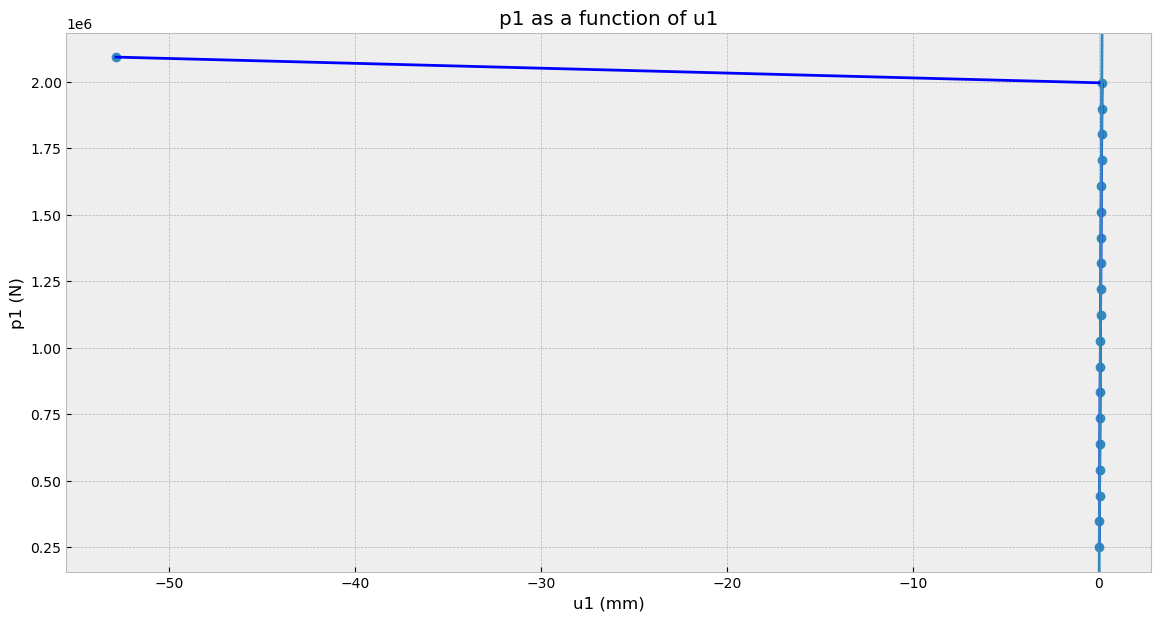

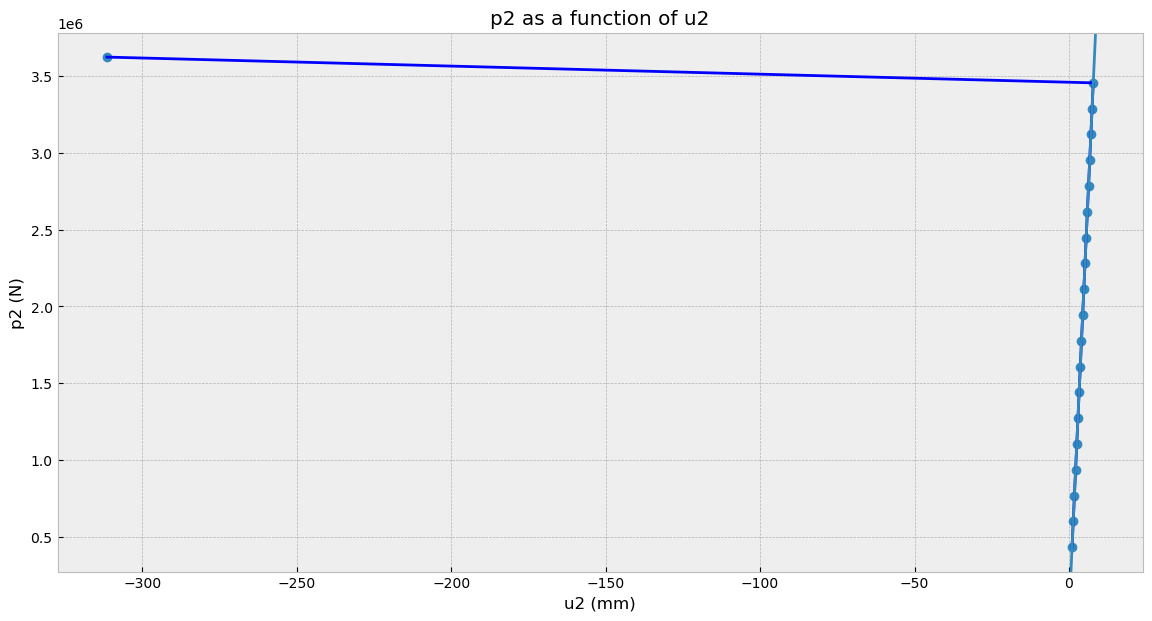

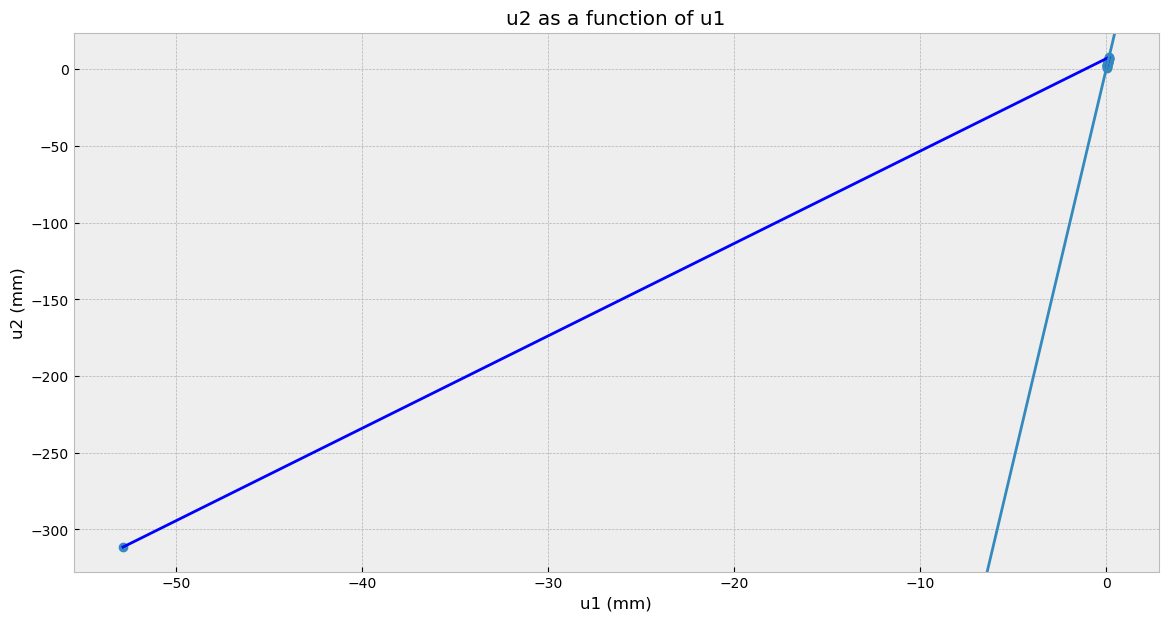

(2,)


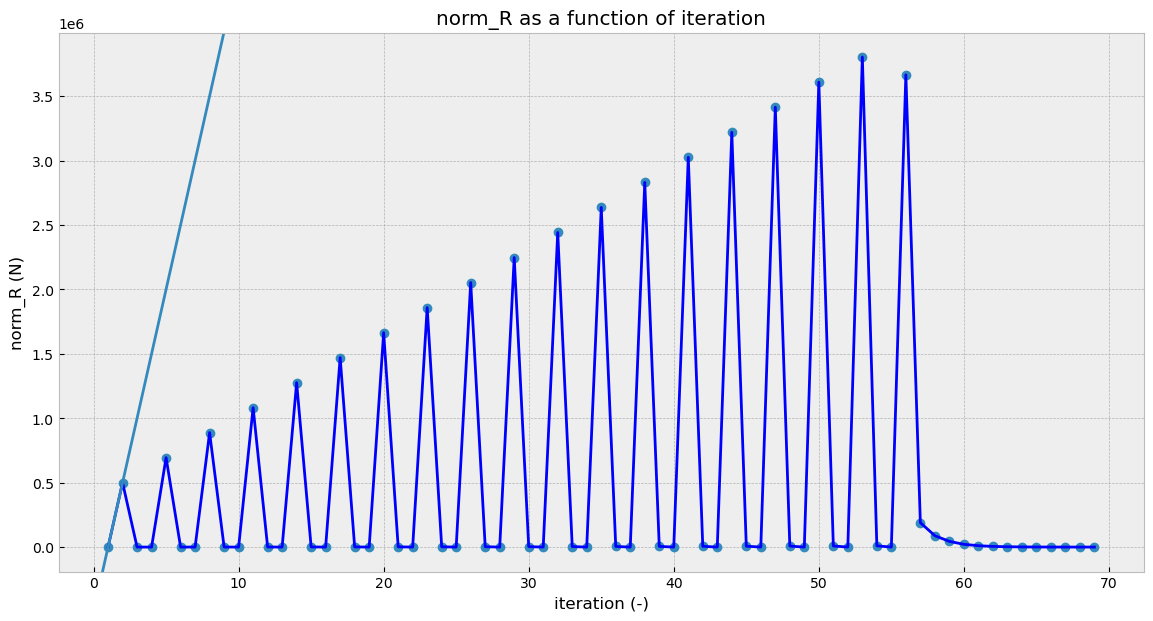

In [21]:
print(u1)
print(p1)
print(E)
printgraph(u1,p1,"u1","p1","mm","N")
printgraph(u2,p2,"u2","p2","mm","N")
printgraph(u1,u2,"u1","u2","mm","mm")
print(r.shape)
printgraph(iteration,norm_r_print,"iteration","norm_R","-","N")